In [ ]:
!pip install seaborn

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
from collections import Counter
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from scipy import stats
import numpy as np

CBR/LCR analysis using PlaToLoCo

In [ ]:
def analyze_platoloco_results(results_file, als_llps_common_entries, non_als_llps_entries):
    """Analyze PlaToLoCo results from JSON file"""
    # Read the JSON results
    with open(results_file, 'r') as f:
        results = json.load(f)

    als_llps_proteins = set(als_llps_common_entries)
    non_als_llps_proteins = set(non_als_llps_entries)

    print(f"\nProtein sets:")
    print(f"ALS-LLPS proteins: {len(als_llps_proteins)}")
    print(f"non-ALS/LLPS proteins: {len(non_als_llps_proteins)}")

    # Create a dictionary to store analysis
    analysis = {
        'protein_id': [],
        'protein_length': [],
        'num_lcrs': [],
        'num_cbrs': [],
        'lcr_coverage': [],
        'cbr_coverage': [],
        'group': []
    }

    # Keep track of processed proteins
    processed_proteins = set()

    print("\nProcessing proteins...")

    # Analyze each protein
    for protein in results['proteins']:
        # Remove the '>' prefix from protein ID
        protein_id = protein['header'].replace('>', '').strip()

        # Skip if already processed
        if protein_id in processed_proteins:
            continue
        processed_proteins.add(protein_id)

        seq_length = protein['length']
        seg_regions = protein.get('SEG', [])
        cast_regions = protein.get('CAST', [])

        # Calculate coverage
        lcr_coverage = sum(r[1] - r[0] for r in seg_regions) / seq_length * 100 if seq_length > 0 else 0
        cbr_coverage = sum(r[1] - r[0] for r in cast_regions) / seq_length * 100 if seq_length > 0 else 0

        # Determine group
        if protein_id in als_llps_proteins:
            group = 'ALS-LLPS'
        elif protein_id in non_als_llps_proteins:
            group = 'non-ALS/LLPS'
        else:
            print(f"Warning: Protein {protein_id} not found in either group")
            continue

        # Store results
        analysis['protein_id'].append(protein_id)
        analysis['protein_length'].append(seq_length)
        analysis['num_lcrs'].append(len(seg_regions))
        analysis['num_cbrs'].append(len(cast_regions))
        analysis['lcr_coverage'].append(lcr_coverage)
        analysis['cbr_coverage'].append(cbr_coverage)
        analysis['group'].append(group)

    df = pd.DataFrame(analysis)

    print("\nAnalysis summary:")
    print(f"Total proteins processed: {len(df)}")
    print("\nGroup counts:")
    print(df['group'].value_counts())

    return df

def plot_results(df):
    """Create visualizations of the results"""
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(15, 15))

    # Boxplots
    plt.subplot(2, 2, 1)
    sns.boxplot(x='group', y='lcr_coverage', data=df)
    plt.title('LCR Coverage by Group')

    plt.subplot(2, 2, 2)
    sns.boxplot(x='group', y='cbr_coverage', data=df)
    plt.title('CBR Coverage by Group')

    # Presence/Absence bar plots
    plt.subplot(2, 2, 3)
    df['has_lcr'] = df['lcr_coverage'] > 0
    sns.countplot(data=df, x='group', hue='has_lcr')
    plt.title('LCR Presence by Group')

    plt.subplot(2, 2, 4)
    df['has_cbr'] = df['cbr_coverage'] > 0
    sns.countplot(data=df, x='group', hue='has_cbr')
    plt.title('CBR Presence by Group')

    plt.tight_layout()
    plt.savefig('platoloco_analysis.png')
    plt.close()

def statistical_analysis(df):
    """Perform both chi-square and t-tests"""
    results = {
        't_tests': {},
        'chi_square': {}
    }

    # T-tests for continuous measures
    for measure in ['num_lcrs', 'num_cbrs', 'lcr_coverage', 'cbr_coverage']:
        als_llps = df[df['group'] == 'ALS-LLPS'][measure]
        non_als_llps = df[df['group'] == 'non-ALS/LLPS'][measure]

        t_stat, p_value = stats.ttest_ind(als_llps, non_als_llps)
        results['t_tests'][measure] = {'t_statistic': t_stat, 'p_value': p_value}

    # Chi-square tests for presence/absence
    for feature, name in [('lcr_coverage', 'LCR'), ('cbr_coverage', 'CBR')]:
        # Create binary variable
        df[f'has_{feature}'] = df[feature] > 0

        # Create contingency table
        contingency = pd.crosstab(df['group'], df[f'has_{feature}'])

        # Perform chi-square test
        chi2, p_value, dof, expected = chi2_contingency(contingency)

        results['chi_square'][name] = {
            'chi2': chi2,
            'p_value': p_value,
            'contingency_table': contingency,
            'dof': dof
        }

    return results

def main():
    results_file = '/content/drive/MyDrive/Protein Bioinformatics/platoloco_results.json'

    df = analyze_platoloco_results(results_file, als_llps_common_entries, non_als_llps_entries)

    df.to_csv('platoloco_analysis1.csv', index=False)

    plot_results(df)

    # Perform statistical analysis
    stats_results = statistical_analysis(df)

    print("\nAnalysis Summary:")
    print("-" * 50)
    print(f"Total proteins analyzed: {len(df)}")
    print(f"ALS-LLPS proteins: {len(df[df['group'] == 'ALS-LLPS'])}")
    print(f"non-ALS/LLPS proteins: {len(df[df['group'] == 'non-ALS/LLPS'])}")

    print("\nT-test Results (Continuous Measures):")
    print("-" * 50)
    for measure, stats in stats_results['t_tests'].items():
        print(f"\n{measure}:")
        print(f"t-statistic: {stats['t_statistic']:.3f}")
        print(f"p-value: {stats['p_value']:.3f}")

    print("\nChi-square Results (Presence/Absence):")
    print("-" * 50)
    for feature, stats in stats_results['chi_square'].items():
        print(f"\n{feature}:")
        print("Contingency Table:")
        print(stats['contingency_table'])
        print(f"Chi-square statistic: {stats['chi2']:.3f}")
        print(f"p-value: {stats['p_value']:.3f}")
        print(f"Degrees of freedom: {stats['dof']}")

if __name__ == "__main__":
    main()


Protein sets:
ALS-LLPS proteins: 48
non-ALS/LLPS proteins: 48

Processing proteins...

Analysis summary:
Total proteins processed: 96

Group counts:
group
ALS-LLPS        48
non-ALS/LLPS    48
Name: count, dtype: int64

Analysis Summary:
--------------------------------------------------
Total proteins analyzed: 96
ALS-LLPS proteins: 48
non-ALS/LLPS proteins: 48

T-test Results (Continuous Measures):
--------------------------------------------------

num_lcrs:
t-statistic: 1.966
p-value: 0.052

num_cbrs:
t-statistic: 1.720
p-value: 0.089

lcr_coverage:
t-statistic: 2.604
p-value: 0.011

cbr_coverage:
t-statistic: 2.327
p-value: 0.022

Chi-square Results (Presence/Absence):
--------------------------------------------------

LCR:
Contingency Table:
has_lcr_coverage  False  True 
group                         
ALS-LLPS              5     43
non-ALS/LLPS         10     38
Chi-square statistic: 1.264
p-value: 0.261
Degrees of freedom: 1

CBR:
Contingency Table:
has_cbr_coverage  False  T

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
als_llps_common_entries = {'P07196', 'P41219', 'P04637', 'P49840', 'Q16236', 'O75477',
                          'O94805', 'Q8WVM8', 'P12036', 'P09651', 'P55072', 'P07737',
                          'P51532', 'Q53GS7', 'O95292', 'Q96LT7', 'P35637', 'O95140',
                          'Q9UKX7', 'P14136', 'Q12840', 'Q9UHD2', 'Q99700', 'P00441',
                          'Q9UHI6', 'P43243', 'P09211', 'Q99615', 'P02649', 'P68366',
                          'P50995', 'P43004', 'P49841', 'Q13148', 'P09429', 'Q9UHD9',
                          'P42658', 'Q96Q42', 'Q8IY17', 'Q13501', 'Q92804', 'P03950',
                          'Q01844', 'Q14203', 'P41002', 'Q9UPW8', 'Q14204', 'Q00059'}

non_als_llps_entries = {'O14964', 'Q8TCF1', 'P46940', 'Q9Y2K5', 'Q9BUQ8', 'Q9Y3C1',
                        'O75127', 'Q9BRT6', 'Q9Y3B9', 'Q8N3I7', 'Q9H0K1', 'O75439',
                        'Q15555', 'P02545', 'Q6IAA8', 'Q9Y2Q3', 'P68106', 'Q9NRM7',
                        'P52732', 'Q9H0H5', 'Q92547', 'P61158', 'Q13618', 'Q8N0Y2',
                        'P62750', 'O43623', 'Q99848', 'P12931', 'P51659', 'Q8IUE6',
                        'Q9UBV8', 'Q2M389', 'Q9NUU7', 'Q14676', 'O75817', 'Q14153',
                        'Q02790', 'P63096', 'Q96CW1', 'Q5W0B1', 'P25205', 'O60218',
                        'Q5SY16', 'O75145', 'P06576', 'Q13045', 'Q6IQ16', 'P04629'}

Sequence Composition Analysis

Loaded 96 sequences from FASTA file

Analyzing sequences...


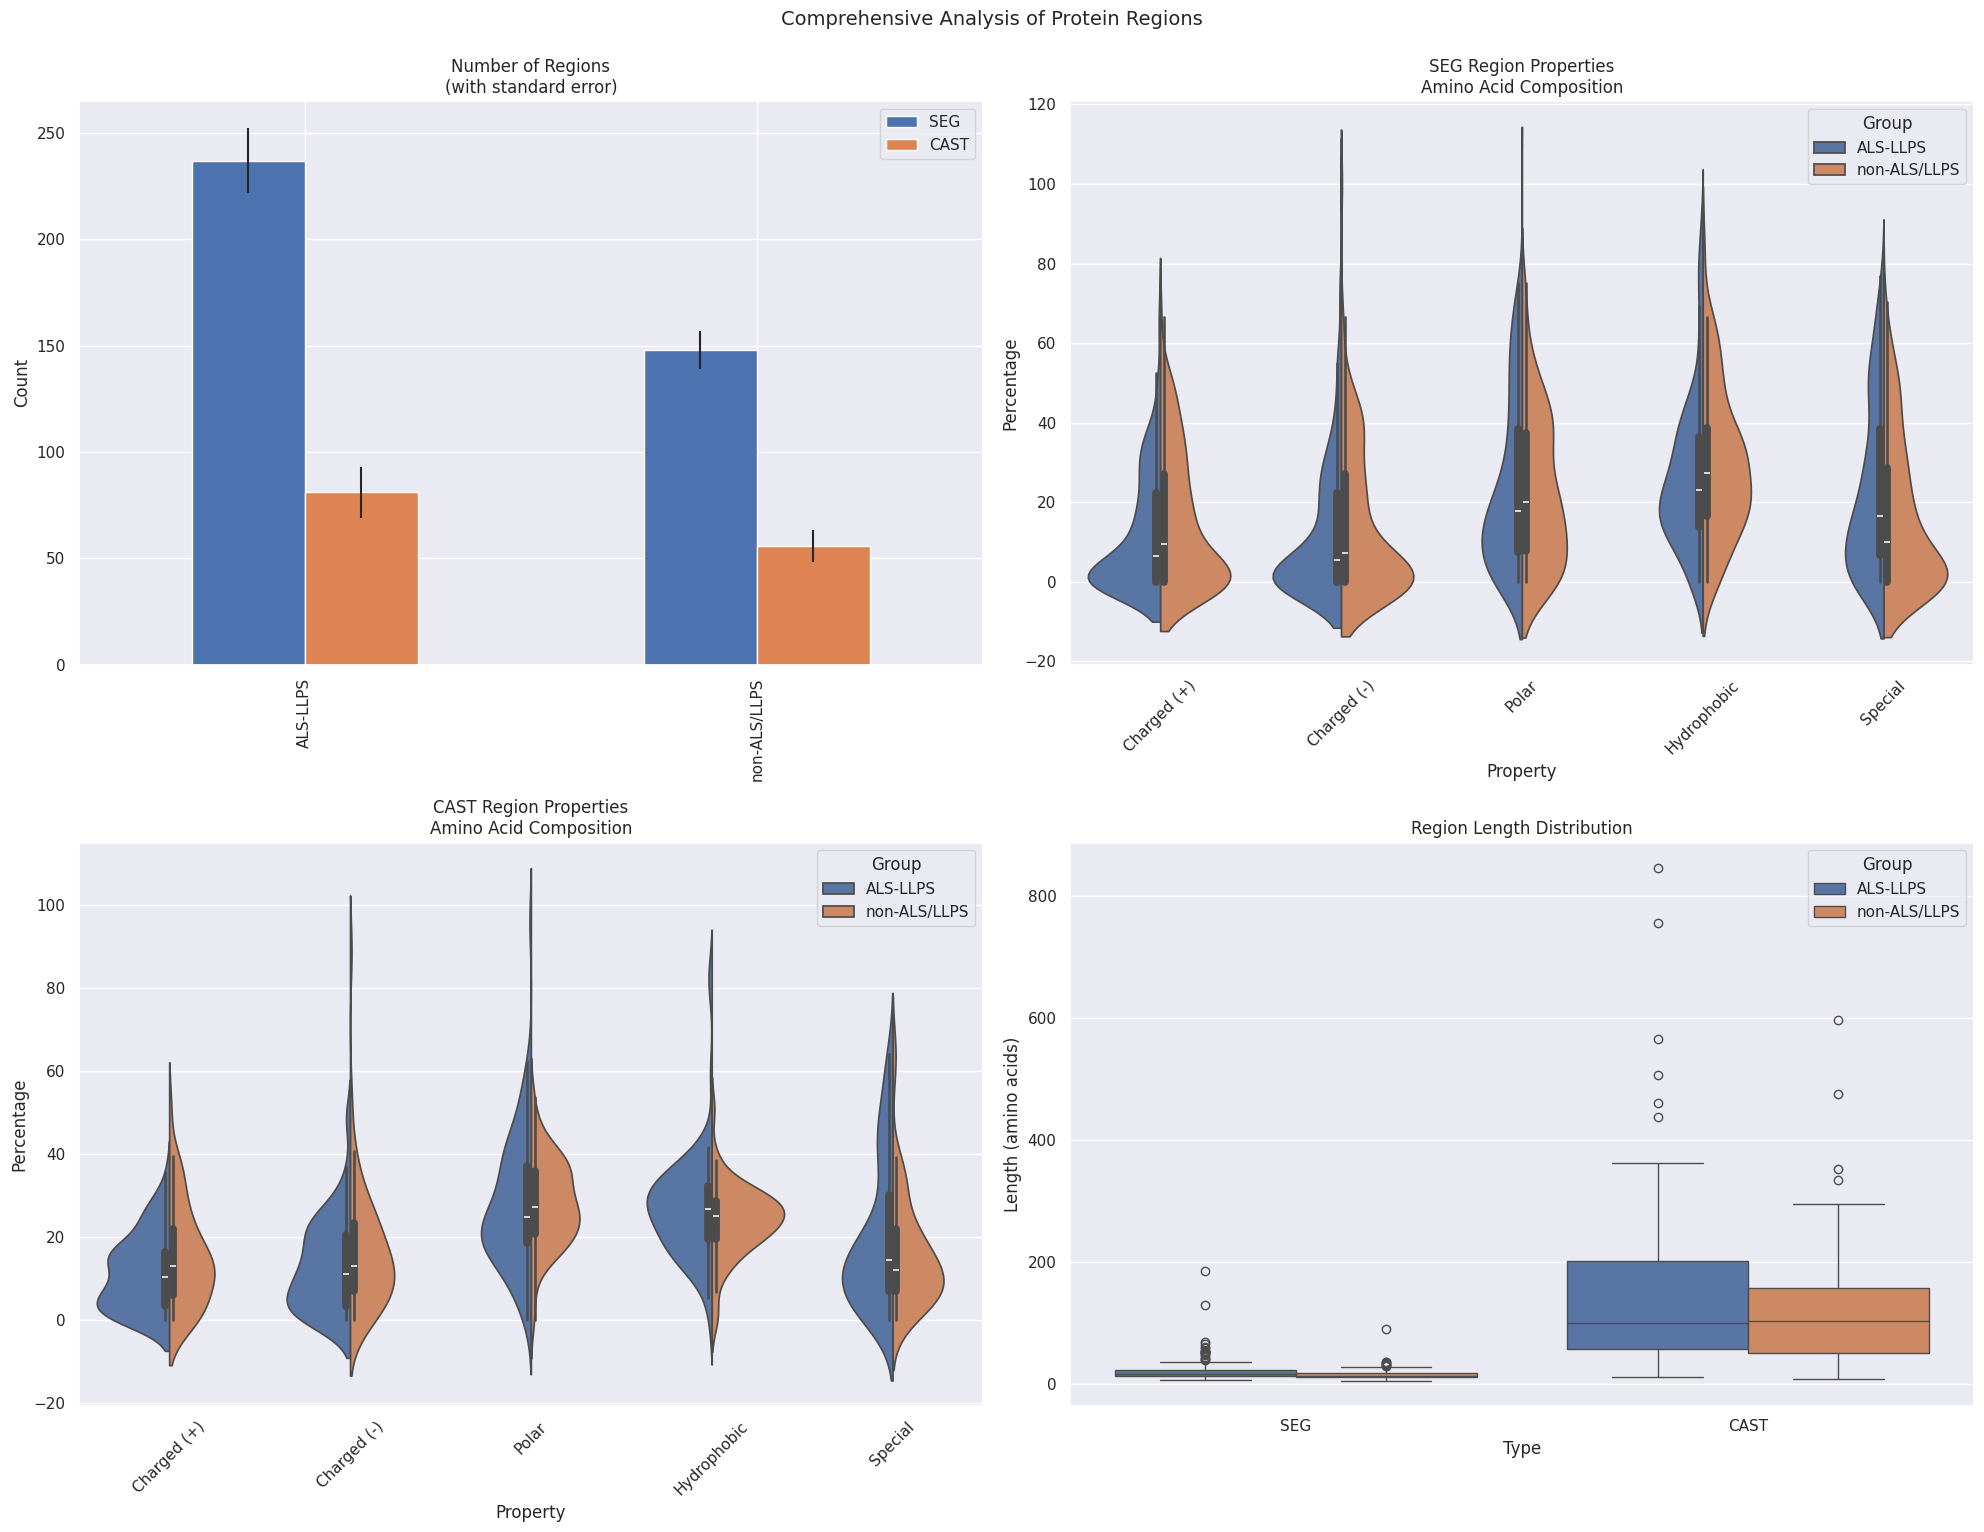


Detailed Statistical Analysis:
--------------------------------------------------

SEG Regions Analysis:

ALS-LLPS:
Number of regions: 237
Length statistics:
  Mean: 21.1
  Median: 16.0
  Std: 17.0
  Min: 7
  Max: 185

non-ALS/LLPS:
Number of regions: 148
Length statistics:
  Mean: 15.9
  Median: 14.0
  Std: 8.7
  Min: 6
  Max: 91

Length comparison:
t-statistic: 3.489
p-value: 0.001

CAST Regions Analysis:

ALS-LLPS:
Number of regions: 81
Length statistics:
  Mean: 160.4
  Median: 100.0
  Std: 157.0
  Min: 12
  Max: 845

non-ALS/LLPS:
Number of regions: 56
Length statistics:
  Mean: 129.8
  Median: 103.5
  Std: 110.8
  Min: 9
  Max: 597

Length comparison:
t-statistic: 1.251
p-value: 0.213

Amino Acid Composition Analysis:
--------------------------------------------------

SEG Regions:

Charged (+) composition:
ALS-LLPS:
  Mean: 12.3%
  Median: 6.6%
  Std: 14.9%
non-ALS/LLPS:
  Mean: 15.3%
  Median: 9.5%
  Std: 16.7%
Statistical comparison:
  t-statistic: -1.761
  p-value: 0.079

Ch

In [ ]:
def read_fasta_sequences(fasta_file):
    """Read sequences from FASTA file"""
    sequences = {}
    current_id = None
    current_seq = []

    with open(fasta_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if current_id:
                    sequences[current_id] = ''.join(current_seq)
                current_id = line[1:].split()[0]
                current_seq = []
            else:
                current_seq.append(line)

    if current_id:
        sequences[current_id] = ''.join(current_seq)

    print(f"Loaded {len(sequences)} sequences from FASTA file")
    return sequences

def analyze_sequences(json_file, fasta_file, als_llps_common_entries, non_als_llps_entries):
    """Analyze amino acid composition in regions"""

    # Load data
    with open(json_file, 'r') as f:
        results = json.load(f)
    sequences = read_fasta_sequences(fasta_file)

    # Store compositions
    compositions = {
        'SEG': {'ALS-LLPS': [], 'non-ALS/LLPS': []},
        'CAST': {'ALS-LLPS': [], 'non-ALS/LLPS': []}
    }

    print("\nAnalyzing sequences...")

    # Process each protein
    for protein in results['proteins']:
        protein_id = protein['header'].replace('>', '').strip()
        sequence = sequences.get(protein_id)

        if not sequence:
            print(f"Warning: No sequence for {protein_id}")
            continue

        # Determine group
        if protein_id in als_llps_common_entries:
            group = 'ALS-LLPS'
        elif protein_id in non_als_llps_entries:
            group = 'non-ALS/LLPS'
        else:
            continue

        # Analyze regions
        for region_type in ['SEG', 'CAST']:
            for start, end in protein.get(region_type, []):
                region_seq = sequence[start:end]
                aa_comp = Counter(region_seq)
                compositions[region_type][group].append({
                    'protein': protein_id,
                    'region': [start, end],
                    'composition': aa_comp,
                    'length': len(region_seq)
                })

    return compositions

def plot_results(compositions):
    """Create enhanced visualizations"""
    # Amino acid groups with more detailed properties
    aa_groups = {
        'Charged (+)': 'RK',
        'Charged (-)': 'DE',
        'Polar': 'STNQH',
        'Hydrophobic': 'AILMFWYV',
        'Special': 'CGP'
    }

    # Create figure with better size and style
    plt.style.use('default')
    sns.set_theme()
    fig = plt.figure(figsize=(20, 15))

    # 1. Region counts with error bars
    ax1 = plt.subplot(2, 2, 1)
    counts = {
        'SEG': {'ALS-LLPS': 0, 'non-ALS/LLPS': 0},
        'CAST': {'ALS-LLPS': 0, 'non-ALS/LLPS': 0}
    }

    for region_type in ['SEG', 'CAST']:
        for group in ['ALS-LLPS', 'non-ALS/LLPS']:
            counts[region_type][group] = len(compositions[region_type][group])

    df_counts = pd.DataFrame(counts)
    df_counts.plot(kind='bar', ax=ax1, yerr=np.sqrt(df_counts.values))
    ax1.set_title('Number of Regions\n(with standard error)', fontsize=12)
    ax1.set_ylabel('Count')

    # 2. Amino acid properties with enhanced visualization
    for i, region_type in enumerate(['SEG', 'CAST']):
        ax = plt.subplot(2, 2, i+2)
        props = {group: {prop: [] for prop in aa_groups}
                for group in ['ALS-LLPS', 'non-ALS/LLPS']}

        for group in ['ALS-LLPS', 'non-ALS/LLPS']:
            for region in compositions[region_type][group]:
                total = sum(region['composition'].values())
                if total > 0:
                    for prop, aas in aa_groups.items():
                        prop_count = sum(region['composition'].get(aa, 0) for aa in aas)
                        props[group][prop].append(prop_count / total * 100)

        # Prepare data for violin plot
        data = []
        labels = []
        groups = []
        for group in props:
            for prop in props[group]:
                data.extend(props[group][prop])
                labels.extend([prop] * len(props[group][prop]))
                groups.extend([group] * len(props[group][prop]))

        # Create violin plot with boxplot inside
        sns.violinplot(x='Property', y='Percentage', hue='Group',
                      data=pd.DataFrame({
                          'Property': labels,
                          'Percentage': data,
                          'Group': groups
                      }), ax=ax, split=True)

        ax.set_title(f'{region_type} Region Properties\nAmino Acid Composition', fontsize=12)
        ax.set_ylabel('Percentage')
        ax.tick_params(axis='x', rotation=45)

    # 3. Add length distribution
    ax4 = plt.subplot(2, 2, 4)
    length_data = []
    length_groups = []
    length_types = []

    for region_type in ['SEG', 'CAST']:
        for group in ['ALS-LLPS', 'non-ALS/LLPS']:
            lengths = [r['length'] for r in compositions[region_type][group]]
            length_data.extend(lengths)
            length_groups.extend([group] * len(lengths))
            length_types.extend([region_type] * len(lengths))

    sns.boxplot(x='Type', y='Length', hue='Group',
                data=pd.DataFrame({
                    'Length': length_data,
                    'Group': length_groups,
                    'Type': length_types
                }), ax=ax4)
    ax4.set_title('Region Length Distribution', fontsize=12)
    ax4.set_ylabel('Length (amino acids)')

    # Adjust layout and style
    plt.tight_layout()

    # Add a title to the entire figure
    fig.suptitle('Comprehensive Analysis of Protein Regions',
                fontsize=14, y=1.02)

    # Save with high resolution
    plt.savefig('sequence_analysis_enhanced.png',
                dpi=300, bbox_inches='tight')
    plt.show()

def analyze_and_print_statistics(compositions):
    """Print detailed statistical analysis"""
    print("\nDetailed Statistical Analysis:")
    print("-" * 50)

    for region_type in ['SEG', 'CAST']:
        print(f"\n{region_type} Regions Analysis:")

        # Basic statistics
        for group in ['ALS-LLPS', 'non-ALS/LLPS']:
            regions = compositions[region_type][group]
            lengths = [r['length'] for r in regions]

            print(f"\n{group}:")
            print(f"Number of regions: {len(regions)}")
            if lengths:
                print(f"Length statistics:")
                print(f"  Mean: {np.mean(lengths):.1f}")
                print(f"  Median: {np.median(lengths):.1f}")
                print(f"  Std: {np.std(lengths):.1f}")
                print(f"  Min: {np.min(lengths)}")
                print(f"  Max: {np.max(lengths)}")

        # Perform statistical tests
        als_lengths = [r['length'] for r in compositions[region_type]['ALS-LLPS']]
        non_als_lengths = [r['length'] for r in compositions[region_type]['non-ALS/LLPS']]

        if als_lengths and non_als_lengths:
            t_stat, p_value = ttest_ind(als_lengths, non_als_lengths)
            print(f"\nLength comparison:")
            print(f"t-statistic: {t_stat:.3f}")
            print(f"p-value: {p_value:.3f}")

def calculate_aa_composition_statistics(compositions):
    """Calculate detailed amino acid composition statistics"""
    # Amino acid groups
    aa_groups = {
        'Charged (+)': 'RK',
        'Charged (-)': 'DE',
        'Polar': 'STNQH',
        'Hydrophobic': 'AILMFWYV',
        'Special': 'CGP'
    }

    print("\nAmino Acid Composition Analysis:")
    print("-" * 50)

    for region_type in ['SEG', 'CAST']:
        print(f"\n{region_type} Regions:")

        # Calculate compositions for each group
        stats_data = {}
        for group in ['ALS-LLPS', 'non-ALS/LLPS']:
            stats_data[group] = {}
            for prop, aas in aa_groups.items():
                prop_percentages = []

                for region in compositions[region_type][group]:
                    total = sum(region['composition'].values())
                    if total > 0:
                        prop_count = sum(region['composition'].get(aa, 0) for aa in aas)
                        prop_percentages.append((prop_count / total) * 100)

                if prop_percentages:
                    stats_data[group][prop] = {
                        'mean': np.mean(prop_percentages),
                        'std': np.std(prop_percentages),
                        'median': np.median(prop_percentages)
                    }

        # Print statistics and perform t-tests
        for prop in aa_groups:
            print(f"\n{prop} composition:")
            for group in ['ALS-LLPS', 'non-ALS/LLPS']:
                stats = stats_data[group][prop]
                print(f"{group}:")
                print(f"  Mean: {stats['mean']:.1f}%")
                print(f"  Median: {stats['median']:.1f}%")
                print(f"  Std: {stats['std']:.1f}%")

            # Perform t-test
            als_vals = [comp['composition'].get(aa, 0) / sum(comp['composition'].values()) * 100
                       for comp in compositions[region_type]['ALS-LLPS']
                       for aa in aa_groups[prop]]
            non_als_vals = [comp['composition'].get(aa, 0) / sum(comp['composition'].values()) * 100
                           for comp in compositions[region_type]['non-ALS/LLPS']
                           for aa in aa_groups[prop]]

            if len(als_vals) > 0 and len(non_als_vals) > 0:
                try:
                    t_stat, p_value = ttest_ind(als_vals, non_als_vals)
                    print(f"Statistical comparison:")
                    print(f"  t-statistic: {t_stat:.3f}")
                    print(f"  p-value: {p_value:.3f}")
                except Exception as e:
                    print(f"Could not perform statistical test: {e}")

def main():
    # File paths
    json_file = '/content/drive/MyDrive/Protein Bioinformatics/platoloco_results.json'
    fasta_file = '/content/drive/MyDrive/Protein Bioinformatics/all_protein_sequences.fasta'

    # Run analysis
    compositions = analyze_sequences(json_file, fasta_file,
                                  als_llps_common_entries,
                                  non_als_llps_entries)

    # Create enhanced visualizations
    plot_results(compositions)

    # Print detailed statistics
    analyze_and_print_statistics(compositions)

    # Print amino acid composition statistics
    calculate_aa_composition_statistics(compositions)

    # Additional statistical analysis for amino acid properties
    print("\nDetailed Property Analysis by Region Type:")
    print("-" * 50)

    aa_groups = {
        'Charged (+)': 'RK',
        'Charged (-)': 'DE',
        'Polar': 'STNQH',
        'Hydrophobic': 'AILMFWYV',
        'Special': 'CGP'
    }

    for region_type in ['SEG', 'CAST']:
        print(f"\n{region_type} Region Analysis:")

        for prop, aas in aa_groups.items():
            # Calculate property percentages for each group
            als_percentages = []
            non_als_percentages = []

            # ALS-LLPS group
            for region in compositions[region_type]['ALS-LLPS']:
                total = sum(region['composition'].values())
                if total > 0:
                    prop_count = sum(region['composition'].get(aa, 0) for aa in aas)
                    als_percentages.append((prop_count / total) * 100)

            # non-ALS/LLPS group
            for region in compositions[region_type]['non-ALS/LLPS']:
                total = sum(region['composition'].values())
                if total > 0:
                    prop_count = sum(region['composition'].get(aa, 0) for aa in aas)
                    non_als_percentages.append((prop_count / total) * 100)

            # Perform statistical test
            if len(als_percentages) > 0 and len(non_als_percentages) > 0:
                t_stat, p_value = ttest_ind(als_percentages, non_als_percentages)

                print(f"\n{prop} Properties:")
                print(f"ALS-LLPS (n={len(als_percentages)}):")
                print(f"  Mean: {np.mean(als_percentages):.1f}%")
                print(f"  Median: {np.median(als_percentages):.1f}%")
                print(f"  Std: {np.std(als_percentages):.1f}%")

                print(f"non-ALS/LLPS (n={len(non_als_percentages)}):")
                print(f"  Mean: {np.mean(non_als_percentages):.1f}%")
                print(f"  Median: {np.median(non_als_percentages):.1f}%")
                print(f"  Std: {np.std(non_als_percentages):.1f}%")

                print("Statistical comparison:")
                print(f"  t-statistic: {t_stat:.3f}")
                print(f"  p-value: {p_value:.3f}")
                if p_value < 0.05:
                    print("  * Significant difference")

if __name__ == "__main__":
    main()

Position Analysis

In [ ]:
def analyze_region_composition(df, results_file):
    """
    Purpose: Determine if/how LCRs and CBRs overlap

    Process:
    - Map LCR and CBR positions
    - Calculate overlap regions
    - Quantify extent of overlap
    """
    try:
        # Read JSON results for sequences
        with open(results_file, 'r') as f:
            results = json.load(f)

        # Dictionary to store region counts and lengths
        analysis = {
            'SEG': {'ALS-LLPS': [], 'non-ALS/LLPS': []},  # For LCRs
            'CAST': {'ALS-LLPS': [], 'non-ALS/LLPS': []}  # For CBRs
        }

        print("\nAnalyzing regions...")

        # Process each protein
        for protein in results['proteins']:
            protein_id = protein['header'].replace('>', '').strip()
            protein_length = protein['length']

            # Get protein group
            if protein_id in als_llps_common_entries:
                group = 'ALS-LLPS'
            elif protein_id in non_als_llps_entries:
                group = 'non-ALS/LLPS'
            else:
                continue

            # Analyze SEG regions (LCRs)
            seg_regions = protein.get('SEG', [])
            seg_coverage = sum(end - start for start, end in seg_regions) / protein_length * 100

            # Analyze CAST regions (CBRs)
            cast_regions = protein.get('CAST', [])
            cast_coverage = sum(end - start for start, end in cast_regions) / protein_length * 100

            # Store results
            analysis['SEG'][group].append({
                'protein_id': protein_id,
                'num_regions': len(seg_regions),
                'coverage': seg_coverage,
                'regions': seg_regions
            })

            analysis['CAST'][group].append({
                'protein_id': protein_id,
                'num_regions': len(cast_regions),
                'coverage': cast_coverage,
                'regions': cast_regions
            })

        # Create summary statistics
        print("\nGenerating summary statistics...")
        summary = create_summary_statistics(analysis)

        # Create visualizations
        print("Creating visualizations...")
        plot_region_analysis(analysis)

        return analysis, summary

    except Exception as e:
        print(f"Error in analysis: {e}")
        return None, None

def create_summary_statistics(analysis):
    """Create summary statistics for the analysis"""
    summary = {}

    for region_type in ['SEG', 'CAST']:
        summary[region_type] = {}
        for group in ['ALS-LLPS', 'non-ALS/LLPS']:
            data = analysis[region_type][group]

            summary[region_type][group] = {
                'num_proteins': len(data),
                'avg_regions_per_protein': np.mean([d['num_regions'] for d in data]),
                'avg_coverage': np.mean([d['coverage'] for d in data]),
                'median_coverage': np.median([d['coverage'] for d in data]),
                'std_coverage': np.std([d['coverage'] for d in data])
            }

    return summary

def plot_region_analysis(analysis):
    """Create visualizations for region analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    # Plot number of regions
    for i, region_type in enumerate(['SEG', 'CAST']):
        data = []
        labels = []
        for group in ['ALS-LLPS', 'non-ALS/LLPS']:
            nums = [d['num_regions'] for d in analysis[region_type][group]]
            data.extend(nums)
            labels.extend([group] * len(nums))

        sns.boxplot(x=labels, y=data, ax=axes[0,i])
        axes[0,i].set_title(f'Number of {region_type} regions')
        axes[0,i].set_ylabel('Count')

    # Plot coverage
    for i, region_type in enumerate(['SEG', 'CAST']):
        data = []
        labels = []
        for group in ['ALS-LLPS', 'non-ALS/LLPS']:
            coverage = [d['coverage'] for d in analysis[region_type][group]]
            data.extend(coverage)
            labels.extend([group] * len(coverage))

        sns.boxplot(x=labels, y=data, ax=axes[1,i])
        axes[1,i].set_title(f'{region_type} coverage (%)')
        axes[1,i].set_ylabel('Coverage (%)')

    plt.tight_layout()
    plt.savefig('region_analysis.png')
    plt.close()

# Run the analysis
results_file = '/content/drive/MyDrive/Protein Bioinformatics/platoloco_results.json'
df = pd.read_csv('/content/drive/MyDrive/Protein Bioinformatics/platoloco_analysis2.csv')

analysis, summary = analyze_region_composition(df, results_file)

if analysis and summary:
    print("\nAnalysis Summary:")
    print("-" * 50)
    for region_type in ['SEG', 'CAST']:
        print(f"\n{region_type} Analysis:")
        for group in ['ALS-LLPS', 'non-ALS/LLPS']:
            stats = summary[region_type][group]
            print(f"\n{group}:")
            print(f"Number of proteins: {stats['num_proteins']}")
            print(f"Average regions per protein: {stats['avg_regions_per_protein']:.2f}")
            print(f"Average coverage: {stats['avg_coverage']:.2f}%")
            print(f"Median coverage: {stats['median_coverage']:.2f}%")
            print(f"Standard deviation of coverage: {stats['std_coverage']:.2f}%")


Analyzing regions...

Generating summary statistics...
Creating visualizations...

Analysis Summary:
--------------------------------------------------

SEG Analysis:

ALS-LLPS:
Number of proteins: 48
Average regions per protein: 4.94
Average coverage: 15.69%
Median coverage: 8.50%
Standard deviation of coverage: 17.72%

non-ALS/LLPS:
Number of proteins: 48
Average regions per protein: 3.08
Average coverage: 8.24%
Median coverage: 6.06%
Standard deviation of coverage: 8.41%

CAST Analysis:

ALS-LLPS:
Number of proteins: 48
Average regions per protein: 1.69
Average coverage: 39.75%
Median coverage: 27.93%
Standard deviation of coverage: 41.84%

non-ALS/LLPS:
Number of proteins: 48
Average regions per protein: 1.17
Average coverage: 22.59%
Median coverage: 8.22%
Standard deviation of coverage: 28.37%


Region Overlap Analysis

In [ ]:
from collections import defaultdict

def analyze_region_overlap(results_file, als_llps_common_entries, non_als_llps_entries):
    """
    Analyze overlap between SEG (LCR) and CAST (CBR) regions
    """
    try:
        # Read JSON results
        with open(results_file, 'r') as f:
            results = json.load(f)

        # Dictionary to store overlap analysis
        overlap_analysis = {
            'ALS-LLPS': [],
            'non-ALS/LLPS': []
        }

        print("\nAnalyzing region overlaps...")

        for protein in results['proteins']:
            protein_id = protein['header'].replace('>', '').strip()
            protein_length = protein['length']

            # Determine group
            if protein_id in als_llps_common_entries:
                group = 'ALS-LLPS'
            elif protein_id in non_als_llps_entries:
                group = 'non-ALS/LLPS'
            else:
                continue

            # Get regions
            seg_regions = protein.get('SEG', [])
            cast_regions = protein.get('CAST', [])

            # Calculate overlaps
            overlaps = find_region_overlaps(seg_regions, cast_regions)

            # Calculate metrics
            overlap_metrics = calculate_overlap_metrics(
                seg_regions, cast_regions, overlaps, protein_length)

            overlap_metrics['protein_id'] = protein_id
            overlap_analysis[group].append(overlap_metrics)

        # Create summary and visualizations
        create_overlap_visualizations(overlap_analysis)
        summary_stats = calculate_overlap_statistics(overlap_analysis)

        return overlap_analysis, summary_stats

    except Exception as e:
        print(f"Error in overlap analysis: {e}")
        return None, None

def find_region_overlaps(seg_regions, cast_regions):
    """
    Find overlapping regions between SEG and CAST
    """
    overlaps = []

    for seg_start, seg_end in seg_regions:
        for cast_start, cast_end in cast_regions:
            # Check for overlap
            if seg_start < cast_end and cast_start < seg_end:
                overlap_start = max(seg_start, cast_start)
                overlap_end = min(seg_end, cast_end)
                overlaps.append([overlap_start, overlap_end])

    return overlaps

def calculate_overlap_metrics(seg_regions, cast_regions, overlaps, protein_length):
    """
    Calculate various metrics for region overlaps
    """
    # Calculate total lengths
    seg_length = sum(end - start for start, end in seg_regions)
    cast_length = sum(end - start for start, end in cast_regions)
    overlap_length = sum(end - start for start, end in overlaps)

    # Calculate coverage percentages
    seg_coverage = (seg_length / protein_length) * 100
    cast_coverage = (cast_length / protein_length) * 100
    overlap_coverage = (overlap_length / protein_length) * 100

    # Calculate overlap percentage relative to regions
    overlap_to_seg = (overlap_length / seg_length * 100) if seg_length > 0 else 0
    overlap_to_cast = (overlap_length / cast_length * 100) if cast_length > 0 else 0

    return {
        'num_seg_regions': len(seg_regions),
        'num_cast_regions': len(cast_regions),
        'num_overlaps': len(overlaps),
        'seg_coverage': seg_coverage,
        'cast_coverage': cast_coverage,
        'overlap_coverage': overlap_coverage,
        'overlap_to_seg': overlap_to_seg,
        'overlap_to_cast': overlap_to_cast,
        'protein_length': protein_length
    }

def create_overlap_visualizations(overlap_analysis):
    """
    Create visualizations for overlap analysis
    """
    fig = plt.figure(figsize=(20, 15))

    # 1. Overlap coverage distribution
    plt.subplot(2, 2, 1)
    data = []
    labels = []
    for group in ['ALS-LLPS', 'non-ALS/LLPS']:
        coverage = [d['overlap_coverage'] for d in overlap_analysis[group]]
        data.extend(coverage)
        labels.extend([group] * len(coverage))

    sns.boxplot(x=labels, y=data)
    plt.title('Overlap Coverage Distribution')
    plt.ylabel('Coverage (%)')

    # 2. Overlap count distribution
    plt.subplot(2, 2, 2)
    data = []
    labels = []
    for group in ['ALS-LLPS', 'non-ALS/LLPS']:
        counts = [d['num_overlaps'] for d in overlap_analysis[group]]
        data.extend(counts)
        labels.extend([group] * len(counts))

    sns.boxplot(x=labels, y=data)
    plt.title('Number of Overlaps Distribution')
    plt.ylabel('Count')

    # 3. Overlap relative to SEG regions
    plt.subplot(2, 2, 3)
    data = []
    labels = []
    for group in ['ALS-LLPS', 'non-ALS/LLPS']:
        percentages = [d['overlap_to_seg'] for d in overlap_analysis[group]]
        data.extend(percentages)
        labels.extend([group] * len(percentages))

    sns.boxplot(x=labels, y=data)
    plt.title('Overlap Relative to SEG Regions')
    plt.ylabel('Percentage of SEG regions')

    # 4. Overlap relative to CAST regions
    plt.subplot(2, 2, 4)
    data = []
    labels = []
    for group in ['ALS-LLPS', 'non-ALS/LLPS']:
        percentages = [d['overlap_to_cast'] for d in overlap_analysis[group]]
        data.extend(percentages)
        labels.extend([group] * len(percentages))

    sns.boxplot(x=labels, y=data)
    plt.title('Overlap Relative to CAST Regions')
    plt.ylabel('Percentage of CAST regions')

    plt.tight_layout()
    plt.savefig('overlap_analysis.png')
    plt.close()

def calculate_overlap_statistics(overlap_analysis):
    """
    Calculate statistical summaries of overlap analysis
    """
    from scipy import stats

    summary = {}
    metrics = ['overlap_coverage', 'num_overlaps', 'overlap_to_seg', 'overlap_to_cast']

    for metric in metrics:
        als_data = [d[metric] for d in overlap_analysis['ALS-LLPS']]
        non_als_data = [d[metric] for d in overlap_analysis['non-ALS/LLPS']]

        # Perform t-test
        t_stat, p_value = stats.ttest_ind(als_data, non_als_data)

        summary[metric] = {
            'ALS-LLPS': {
                'mean': np.mean(als_data),
                'median': np.median(als_data),
                'std': np.std(als_data)
            },
            'non-ALS/LLPS': {
                'mean': np.mean(non_als_data),
                'median': np.median(non_als_data),
                'std': np.std(non_als_data)
            },
            'statistics': {
                't_statistic': t_stat,
                'p_value': p_value
            }
        }

    return summary

def main():
    results_file = '/content/drive/MyDrive/Protein Bioinformatics/platoloco_results.json'

    # Run overlap analysis
    overlap_analysis, summary_stats = analyze_region_overlap(
        results_file,
        als_llps_common_entries,
        non_als_llps_entries
    )

    if overlap_analysis and summary_stats:
        print("\nOverlap Analysis Summary:")
        print("-" * 50)

        for metric in summary_stats:
            print(f"\n{metric}:")
            for group in ['ALS-LLPS', 'non-ALS/LLPS']:
                stats = summary_stats[metric][group]
                print(f"\n{group}:")
                print(f"Mean: {stats['mean']:.2f}")
                print(f"Median: {stats['median']:.2f}")
                print(f"Std: {stats['std']:.2f}")

            # Print statistical test results
            test_stats = summary_stats[metric]['statistics']
            print("\nStatistical Test:")
            print(f"t-statistic: {test_stats['t_statistic']:.3f}")
            print(f"p-value: {test_stats['p_value']:.3f}")

if __name__ == "__main__":
    main()


Analyzing region overlaps...

Overlap Analysis Summary:
--------------------------------------------------

overlap_coverage:

ALS-LLPS:
Mean: 16.86
Median: 6.07
Std: 28.07

non-ALS/LLPS:
Mean: 6.87
Median: 1.43
Std: 12.75

Statistical Test:
t-statistic: 2.221
p-value: 0.029

num_overlaps:

ALS-LLPS:
Mean: 5.15
Median: 1.50
Std: 8.66

non-ALS/LLPS:
Mean: 2.21
Median: 1.00
Std: 3.51

Statistical Test:
t-statistic: 2.156
p-value: 0.034

overlap_to_seg:

ALS-LLPS:
Mean: 64.21
Median: 74.36
Std: 55.39

non-ALS/LLPS:
Mean: 47.11
Median: 31.11
Std: 55.34

Statistical Test:
t-statistic: 1.497
p-value: 0.138

overlap_to_cast:

ALS-LLPS:
Mean: 30.56
Median: 18.06
Std: 31.24

non-ALS/LLPS:
Mean: 19.41
Median: 8.50
Std: 27.34

Statistical Test:
t-statistic: 1.841
p-value: 0.069


Position Analysis

In [ ]:
from scipy import stats

def analyze_region_positions(results_file, als_llps_common_entries, non_als_llps_entries):
    """
    Analyze where LCRs and CBRs tend to occur in proteins
    """
    try:
        with open(results_file, 'r') as f:
            results = json.load(f)

        position_analysis = {
            'ALS-LLPS': {'SEG': [], 'CAST': []},
            'non-ALS/LLPS': {'SEG': [], 'CAST': []}
        }

        print("\nAnalyzing region positions...")

        for protein in results['proteins']:
            protein_id = protein['header'].replace('>', '').strip()
            protein_length = protein['length']

            # Determine group
            if protein_id in als_llps_common_entries:
                group = 'ALS-LLPS'
            elif protein_id in non_als_llps_entries:
                group = 'non-ALS/LLPS'
            else:
                continue

            # Analyze positions
            seg_positions = analyze_positions(protein.get('SEG', []), protein_length)
            cast_positions = analyze_positions(protein.get('CAST', []), protein_length)

            # Store results
            position_analysis[group]['SEG'].append({
                'protein_id': protein_id,
                'length': protein_length,
                'positions': seg_positions
            })

            position_analysis[group]['CAST'].append({
                'protein_id': protein_id,
                'length': protein_length,
                'positions': cast_positions
            })

        # Create visualizations and calculate statistics
        create_position_visualizations(position_analysis)
        summary_stats = calculate_position_statistics(position_analysis)

        return position_analysis, summary_stats

    except Exception as e:
        print(f"Error in position analysis: {e}")
        return None, None

def analyze_positions(regions, protein_length):
    """
    Analyze positions of regions relative to protein length
    """
    if not regions:
        return {
            'n_terminal': 0,
            'middle': 0,
            'c_terminal': 0,
            'relative_positions': []
        }

    # Define regions (0-30%, 30-70%, 70-100% of protein length)
    n_term_cutoff = 0.3 * protein_length
    c_term_cutoff = 0.7 * protein_length

    n_terminal = 0
    middle = 0
    c_terminal = 0
    relative_positions = []

    for start, end in regions:
        # Calculate region midpoint and relative position
        midpoint = (start + end) / 2
        relative_pos = midpoint / protein_length
        relative_positions.append(relative_pos)

        # Count region location
        if midpoint < n_term_cutoff:
            n_terminal += 1
        elif midpoint > c_term_cutoff:
            c_terminal += 1
        else:
            middle += 1

    return {
        'n_terminal': n_terminal,
        'middle': middle,
        'c_terminal': c_terminal,
        'relative_positions': relative_positions
    }

def create_position_visualizations(position_analysis):
    """
    Create visualizations for position analysis
    """
    fig = plt.figure(figsize=(20, 15))

    # 1. Distribution of relative positions
    plt.subplot(2, 2, 1)
    for group in ['ALS-LLPS', 'non-ALS/LLPS']:
        for region_type in ['SEG', 'CAST']:
            positions = []
            for protein in position_analysis[group][region_type]:
                positions.extend(protein['positions']['relative_positions'])

            sns.kdeplot(data=positions, label=f"{group}-{region_type}")

    plt.title('Distribution of Region Positions')
    plt.xlabel('Relative Position (0=N-term, 1=C-term)')
    plt.ylabel('Density')
    plt.legend()

    # 2. Region counts by location
    locations = ['n_terminal', 'middle', 'c_terminal']

    plt.subplot(2, 2, 2)
    data = []
    for group in ['ALS-LLPS', 'non-ALS/LLPS']:
        for region_type in ['SEG', 'CAST']:
            for loc in locations:
                count = sum(p['positions'][loc] for p in position_analysis[group][region_type])
                data.append({
                    'Group': group,
                    'Region': region_type,
                    'Location': loc,
                    'Count': count
                })

    df = pd.DataFrame(data)
    sns.barplot(data=df, x='Location', y='Count', hue='Group')
    plt.title('Region Counts by Location')

    # 3. Heatmap of position preferences
    plt.subplot(2, 2, 3)
    heatmap_data = np.zeros((2, 3))
    for i, group in enumerate(['ALS-LLPS', 'non-ALS/LLPS']):
        total = sum(len(p['positions']['relative_positions'])
                   for p in position_analysis[group]['SEG'])
        if total > 0:
            heatmap_data[i,0] = sum(p['positions']['n_terminal']
                                  for p in position_analysis[group]['SEG']) / total
            heatmap_data[i,1] = sum(p['positions']['middle']
                                  for p in position_analysis[group]['SEG']) / total
            heatmap_data[i,2] = sum(p['positions']['c_terminal']
                                  for p in position_analysis[group]['SEG']) / total

    sns.heatmap(heatmap_data, xticklabels=['N-term', 'Middle', 'C-term'],
                yticklabels=['ALS-LLPS', 'non-ALS/LLPS'], annot=True, fmt='.2f')
    plt.title('Position Preferences (normalized)')

    plt.tight_layout()
    plt.savefig('position_analysis.png')
    plt.close()

def calculate_position_statistics(position_analysis):
    """
    Calculate statistical summaries of position analysis
    """
    summary = {}

    for region_type in ['SEG', 'CAST']:
        summary[region_type] = {}

        # Collect position data
        als_positions = []
        non_als_positions = []

        for protein in position_analysis['ALS-LLPS'][region_type]:
            als_positions.extend(protein['positions']['relative_positions'])

        for protein in position_analysis['non-ALS/LLPS'][region_type]:
            non_als_positions.extend(protein['positions']['relative_positions'])

        # Perform statistical tests
        if als_positions and non_als_positions:
            t_stat, p_value = stats.ttest_ind(als_positions, non_als_positions)

            summary[region_type] = {
                'ALS-LLPS': {
                    'mean_position': np.mean(als_positions),
                    'median_position': np.median(als_positions),
                    'std_position': np.std(als_positions)
                },
                'non-ALS/LLPS': {
                    'mean_position': np.mean(non_als_positions),
                    'median_position': np.median(non_als_positions),
                    'std_position': np.std(non_als_positions)
                },
                'statistics': {
                    't_statistic': t_stat,
                    'p_value': p_value
                }
            }

    return summary

def main():
    results_file = '/content/drive/MyDrive/Protein Bioinformatics/platoloco_results.json'

    # Run position analysis
    position_analysis, summary_stats = analyze_region_positions(
        results_file,
        als_llps_common_entries,
        non_als_llps_entries
    )

    if position_analysis and summary_stats:
        print("\nPosition Analysis Summary:")
        print("-" * 50)

        for region_type in ['SEG', 'CAST']:
            print(f"\n{region_type} Regions:")
            for group in ['ALS-LLPS', 'non-ALS/LLPS']:
                stats = summary_stats[region_type][group]
                print(f"\n{group}:")
                print(f"Mean position: {stats['mean_position']:.3f}")
                print(f"Median position: {stats['median_position']:.3f}")
                print(f"Std position: {stats['std_position']:.3f}")

            test_stats = summary_stats[region_type]['statistics']
            print("\nStatistical Test:")
            print(f"t-statistic: {test_stats['t_statistic']:.3f}")
            print(f"p-value: {test_stats['p_value']:.3f}")

if __name__ == "__main__":
    main()


Analyzing region positions...

Position Analysis Summary:
--------------------------------------------------

SEG Regions:

ALS-LLPS:
Mean position: 0.443
Median position: 0.419
Std position: 0.315

non-ALS/LLPS:
Mean position: 0.471
Median position: 0.460
Std position: 0.301

Statistical Test:
t-statistic: -0.841
p-value: 0.401

CAST Regions:

ALS-LLPS:
Mean position: 0.476
Median position: 0.450
Std position: 0.306

non-ALS/LLPS:
Mean position: 0.526
Median position: 0.527
Std position: 0.269

Statistical Test:
t-statistic: -0.987
p-value: 0.325
